In [134]:
from algames import ALGAMES

import numpy as np
import matplotlib.pyplot as plt

In [135]:
# M players
M = 3

# N horizon length
N = 10

# n state size
n = 4  # (x, y, v_x, v_y)

# m control input size
m = 2  # (a_x, a_y)

# timestep
dt = 0.1

# collision avoidance radius
r = 0.33

# running cost matrix
Q = np.eye(n)

# terminal cost matrix
Qf = np.eye(n) * 100

# control cost matrix
R = np.eye(m)

# penalty gain
rho = 1

# penalty schedule
gamma = 10

# convergence tolerance
eps = 1e-5

# max iterations
max_iter = 20

# multiplier to enforce dynamics
dynamics_mult = 100

In [136]:
# initial state
# initial state
x1_0 = np.array([1, 0, 1.5, 0])
x2_0 = np.array([0.1, 0, 1.5, 0])
x3_0 = np.array([0.1, 0.5, 2, 0])
list_x0 = [x1_0, x2_0, x3_0]

# final state
x1_f = np.array([3, 0, 2, 0])
x2_f = np.array([2, 0, 2, 0])
x3_f = np.array([2.5, 0, 2, 0])
list_xf = [x1_f, x2_f, x3_f]


# constraints
constraint_wall_y = 1
constraint_u_x_max = 5
constraint_u_y_max = constraint_u_x_max

In [137]:
X, U = ALGAMES(
    M,  # number players
    N,  # horizon
    dt,  # timestep
    r,  # collision avoidance radius
    list_x0,  # list of initial states
    list_xf,  # list of target states
    Q,  # running cost matrix
    Qf,  # terminal cost matrix
    R,  # control cost matrix
    rho,  # constraint penalty value
    gamma,  # constraint penalty schedule
    eps,  # convergence tolerance
    constraint_wall_y,  # y value of horizontal wall
    constraint_u_x_max,  # control input x bound
    constraint_u_y_max,  # control input y bound
    max_iter,
    dynamics_mult,
)

0 y_max=2.999 rho=1 C_vio=-0.049
1 y_max=2.999 rho=10 C_vio=-0.049
2 y_max=2.999 rho=100 C_vio=-0.049
3 y_max=2.999 rho=1000 C_vio=-0.049
4 y_max=2.999 rho=10000 C_vio=-0.049
5 y_max=2.999 rho=100000 C_vio=-0.049
6 y_max=2.999 rho=1000000 C_vio=-0.049
7 y_max=2.999 rho=10000000 C_vio=-0.049
8 y_max=2.999 rho=100000000 C_vio=-0.049


Text(0.5, 1.0, 'Position')

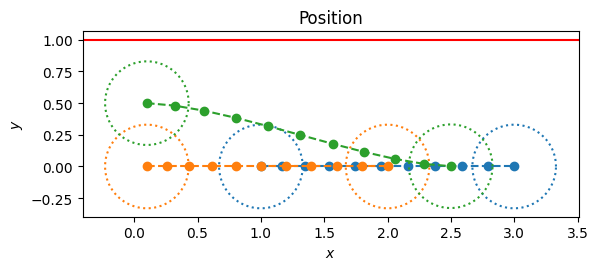

In [138]:
x_players = np.split(X, M)

# safety radius
th = np.linspace(0, 2 * np.pi, 180)
c_cos = np.cos(th) * r
c_sin = np.sin(th) * r

# plot
plt.figure()
for i, x in enumerate(x_players):
    x1 = x[n:2*n]
    x = np.reshape(x, (n, N), order="F")
    x0 = np.reshape(list_x0[i], (n, 1))
    x = np.hstack((x0, x))
    
    plt.plot(x[0, :], x[1, :], "o--")

    # plot cola radius
    plt.plot(x[0, 0] + c_cos, x[1, 0] + c_sin, ":", c=f"C{i}")
    plt.plot(x[0, -1] + c_cos, x[1, -1] + c_sin, ":", c=f"C{i}")
plt.axhline(constraint_wall_y, c="r")
plt.gca().set_aspect("equal")
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Position")

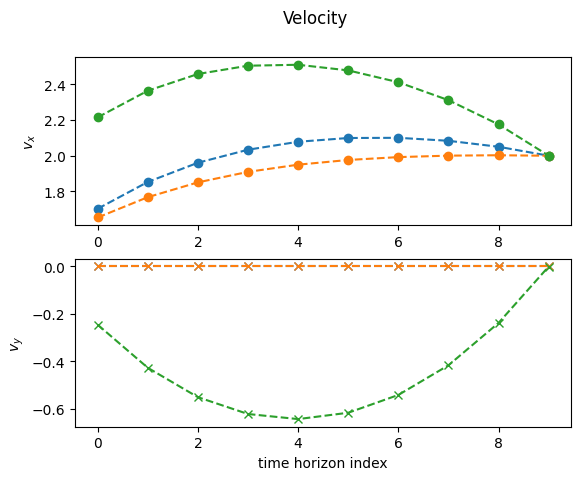

In [139]:
# velocity
plt.figure()
for i, x in enumerate(x_players):
    x = np.reshape(x, (n, N), order="F")
    ax = plt.subplot(211)
    ax.plot(x[2, :], "o--", c=f"C{i}")
    plt.ylabel("$v_x$")
    ax = plt.subplot(212)
    ax.plot(x[3, :], "x--", c=f"C{i}")
    plt.ylabel('$v_y$')
plt.xlabel('time horizon index')
plt.suptitle("Velocity");

Text(0.5, 0.98, 'Control Input')

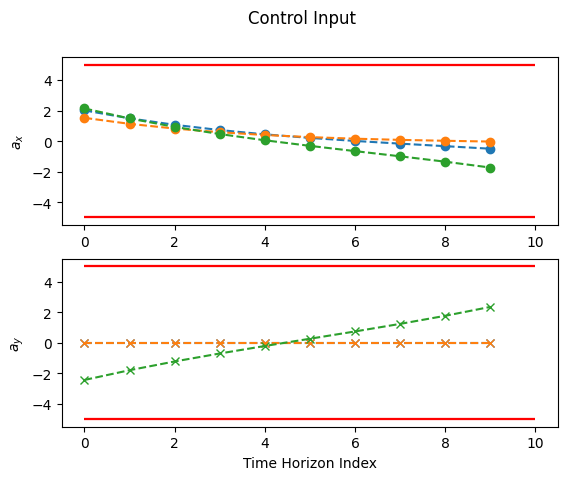

In [140]:
u_players = np.split(U, M)

# plot
plt.figure()
for i, u in enumerate(u_players):
    u = np.reshape(u, (m, N), order="F")
    ax = plt.subplot(211)
    plt.plot(u[0, :], "o--", c=f"C{i}")
    plt.hlines((constraint_u_x_max, -constraint_u_x_max), 0, N, "r")
    plt.ylabel("$a_x$")
    ax = plt.subplot(212)
    plt.plot(u[1, :], "x--", c=f"C{i}")
    plt.hlines((constraint_u_y_max, -constraint_u_y_max), 0, N, "r")
    plt.ylabel('$a_y$')
plt.xlabel('Time Horizon Index')
plt.suptitle("Control Input")

-0.1436


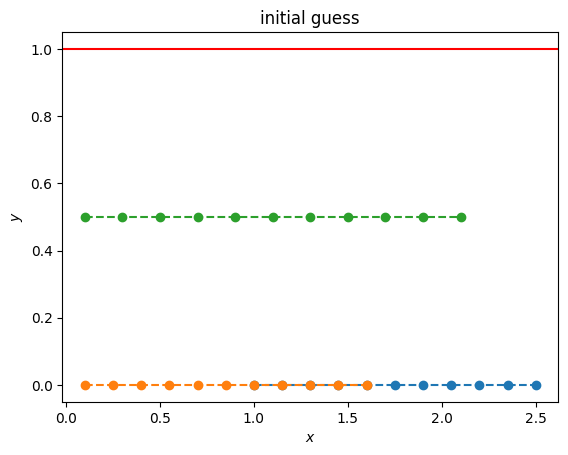

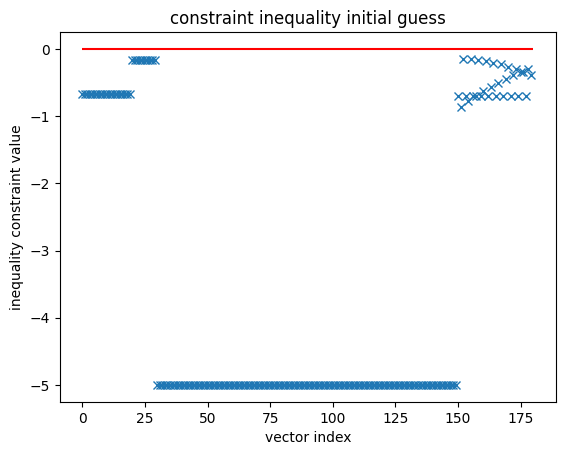

In [141]:
import initial_guess
import constraints

y0, X_guess, U_guess, mu_guess = initial_guess.generate(list_x0, M, N, n, m, dt)
x_players = np.split(X_guess, M)
plt.figure()
for i, x in enumerate(x_players):
    x = np.reshape(x, (n, N), order="F")
    x0 = np.reshape(list_x0[i], (n, 1))
    x = np.hstack((x0, x))
    plt.plot(x[0, :], x[1, :], "o--")
plt.axhline(constraint_wall_y, c="r")

plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("initial guess")

# check constraints
C0 = constraints.C(
    X_guess,
    U_guess,
    *constraints.get_system_wall_y(constraint_wall_y, r, M, N, n),
    *constraints.get_system_input_bound(
        M, N, m, constraint_u_x_max, constraint_u_y_max
    ),
    r,
    constraints.get_system_cola(M, N, n)
)

plt.figure()
plt.plot(C0, "x")
plt.hlines((0,), 0, len(C0), "r")
plt.title("constraint inequality initial guess")
plt.xlabel("vector index")
plt.ylabel("inequality constraint value")
plt.ticklabel_format(axis="y", style="sci", scilimits=(3, -3))
print(max(C0))

Text(0.5, 1.0, 'I_rho')

<Figure size 640x480 with 0 Axes>

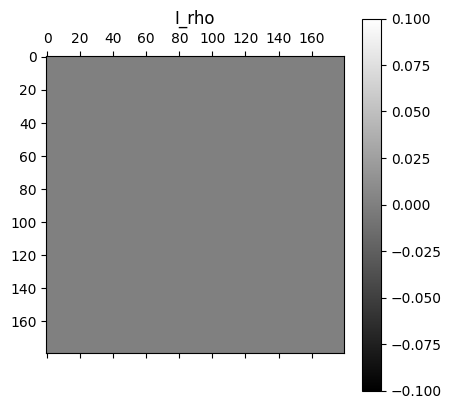

In [142]:
# check I_rho
import penalty

lam = np.zeros(len(C0))
I_rho = penalty.Irho(C0, lam, rho)
plt.figure()
plt.matshow(I_rho, cmap="gray")
plt.colorbar()
plt.title("I_rho")

-0.04927162387967769


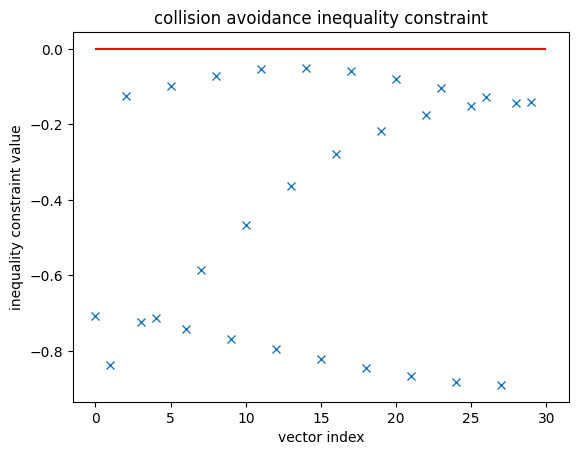

In [143]:
# check collision avoidance
import constraints

cola = constraints.C_cola(X, U, r, constraints.get_system_cola(M, N, n))

plt.figure()
plt.plot(cola, "x")
plt.hlines((0,), 0, N * M, "r")
plt.title("collision avoidance inequality constraint")
plt.xlabel("vector index")
plt.ylabel("inequality constraint value")
print(max(cola))

-0.04927162387967769


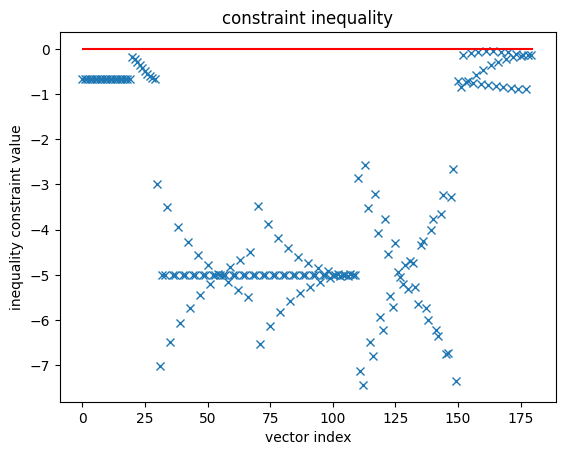

In [144]:
# check all constraints
import dynamics

C = constraints.C(
    X,
    U,
    *constraints.get_system_wall_y(constraint_wall_y, r, M, N, n),
    *constraints.get_system_input_bound(
        M, N, m, constraint_u_x_max, constraint_u_y_max
    ),
    r,
    constraints.get_system_cola(M, N, n)
)

plt.figure()
plt.plot(C, "x")
plt.hlines((0,), 0, len(C), "r")
plt.title("constraint inequality")
plt.xlabel("vector index")
plt.ylabel("inequality constraint value")
plt.ticklabel_format(axis="y", style="sci", scilimits=(3, -3))
print(max(C))

0.007552628243015336


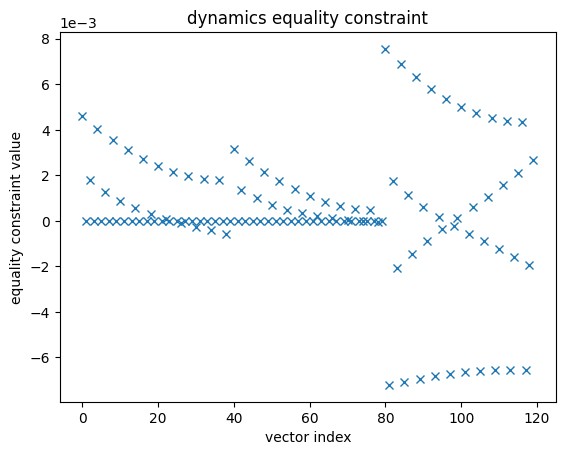

In [145]:
# check dynamics
import dynamics

D = dynamics.D(X, U, *dynamics.get_system_dynamics(M, N, n, m, dt), np.hstack(list_x0))

plt.figure()
plt.plot(D, "x")
plt.title("dynamics equality constraint")
plt.xlabel("vector index")
plt.ylabel("equality constraint value")
plt.ticklabel_format(axis="y", style="sci", scilimits=(3, -3))
print(max(D))